# **Review of Ivado-Mila Deep Learning School Spring 2021**

**Author** : Joris Christopher Tabeu

In [1]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0

Requirement already up-to-date: pillow==8.1.0 in /usr/local/lib/python3.7/dist-packages (8.1.0)


Loading of all the libraries we need to do the work

In [5]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 'numpy']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.9.0+cu102
GPU Available: False


Fix the seed for the different librairies

In [12]:
seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

We will use the CIFAR-10 dataset.
In this section, we provide a function for downloading the CIFAR-10 dataset. It takes as input two arguments:
- **path**: the directory where the downloaded dataset will be saved.
- **train_flag**: boolean flag indicating whether to download data from the training set (`train_flag=True`) or the test set (`train_flag=False`).

It returns two elements, namely:
- **imgs**: NumPy array representing the downloaded images of size N x 32 x 32 x 3 where N is the number of images.
- **labels**: list of N (indexed-)classes, each associated with a single image.

In [7]:
def download_CIFAR10(path, train_flag):
  """
  Args:
     path: the directory where the dowloaded dataset will be saved.
     train_flag: if `True`, download data from training set, otherwise
        download from test set.
        
  Return:
     A tuple of two elements (imgs, labels) where
        imgs: a numpy array of shape N x 32 x 32 x 3 where N is the number of images.
        labels: list of N (indexed-)classes, each  associated with a single image.
  
  """
  dataset = torchvision.datasets.CIFAR10(
      root=path, train=train_flag, download=True
  )
  imgs, labels = dataset.data, dataset.targets
  return imgs, labels

#### Download the CIFAR-10 dataset and retrieve the training set & test set

In [8]:
imgs, labels = download_CIFAR10('./', True)


Extracting ./cifar-10-python.tar.gz to ./


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
test_imgs, test_labels = download_CIFAR10('./', False)

Files already downloaded and verified


### Data split

In the previous section, we provide functions to download the **train** and **test** datasets. Usually, we need three sets of data in a ML project: train, **validation**, and test sets. Unfortunately, the CIFAR-10 dataset does not contain a preprocessed validation set; therefore, we need to create a **custom** one by sampling from the **training** set.

In this section, we provide a function for creating a validation set from the original training set. It takes as input five arguments:
- **imgs**: NumPy array representing the image set from which the partitioning is made.
- **labels**: labels associated with the provided image set.
- **valid_ratio** (optional): a proportion of the data that will be used for the validation set. Default: `0.3`.
- **shuffle** (optional): whether or not the data need to be shuffled before the partitioning is made. Default: `True`.
- **seed** (optional): the seed of the random generator. Default: `1234`.

It provides as output 4 elements, which are:
- **train_imgs**: NumPy array representing the images of the training set after the splitting is done.
- **train_labels**: labels associated with the images of the training set.
- **valid_imgs**: NumPy array representing the images of the validation set after the splitting is done.
- **valid_labels**: labels associated with the images of the validation set.

In [13]:
def partition_dataset(imgs, labels, valid_ratio=0.3, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the partitioning is made.
     labels: the labels associated with the provided images.
     valid_ratio (optional): the proportion of the data that will be used in
        the validation set. Default: 0.3.
     shuffle (optional): whether or not to shuffle the data. Default: True.
     seed (optional): the seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 4 elements (train_imgs, train_labels, valid_imgs, valid_labels)
     where:
        train_imgs: a numpy array of images for the training set.
        train_labels: labels associated with the images in the training set.
        valid_imgs: a numpy array of images for the validation set.
        valid_labels: labels associated with the images in the validation set.
  
  """
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  
  train_idx, valid_idx = np.split(
      indices, 
      [int((1.0 - valid_ratio)*len(indices))]
  )
  train_imgs, valid_imgs = imgs[train_idx], imgs[valid_idx]
  labels = np.array(labels)
  train_labels, valid_labels = labels[train_idx].tolist(), labels[valid_idx].tolist()
  return train_imgs, train_labels, valid_imgs, valid_labels
  

Generate the custom training and validation sets by using partition_dataset with the default parameters.

In [14]:
train_imgs, train_labels, valid_imgs, valid_labels = partition_dataset(imgs=imgs, labels=labels)

### Data visualization

Before training any model, you should do some sanity checks of the data to ensure that the retrieval and the split were correctly done.

This section provides some functions for visualizing image data and computing the label distribution within a dataset.

In [16]:
import matplotlib.pyplot as plt


def plot_image(img):
  """
  Plot a single image.
  
  Args:
     img: image to be plotted.
     
  """
  plt.imshow(img)
  plt.show()

  
def plot_random_images(imgs, n):  
  """
  Randomly sample n images from an image set and plot them in a grid.
  
  Args:
     imgs: collection of images from which sampling will be made.
     n: the number of images to be sampled.
     
  """
  sampled_indices = np.random.choice(imgs.shape[0], n, False)
  sampled_images = imgs[sampled_indices]
  
  sampled_images = np.transpose(sampled_images, (0, 3, 1, 2))
  sampled_tensor = torch.Tensor(sampled_images)
  
  grid_tensor = torchvision.utils.make_grid(
      sampled_tensor, normalize=True, value_range=(0, 255)
  )
  grid_tensor = np.transpose(grid_tensor.numpy(), (1, 2, 0))
  
  plot_image(grid_tensor)
  
  
def plot_dataset_histogram(labels, title='Label distribution', rel_freq=False):
  """
  Plot the histogram/distribution of the labels within a dataset.
  
  Args:
     labels: collection of labels from which the distribution is computed.
     title: the title of the histogram.
     rel_freq: if true, the histogram is normalized to show relative frequencies
               otherwise, it shows the frequencies.
     
  """
  _ = plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.85, density=rel_freq)
  plt.title(title)
  plt.xlabel('Label')
  if rel_freq:
    plt.ylabel('Relative frequency')
  else:
    plt.ylabel('Frequency')
  plt.xticks(np.arange(10))
  plt.show()


Use the previously defined functions to visualize samples from training and validation sets. Also, compute the label distributions for these two sets. Comment on your observations.

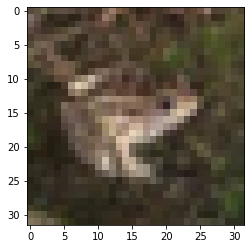

In [18]:
plot_image(imgs[22])

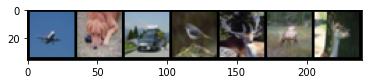

In [21]:
plot_random_images(imgs=imgs, n=7)

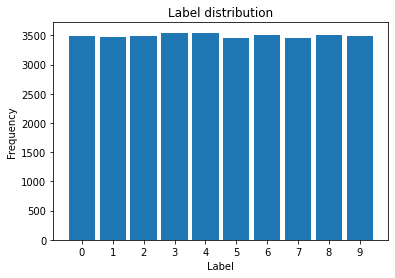

In [22]:
plot_dataset_histogram(labels=train_labels)

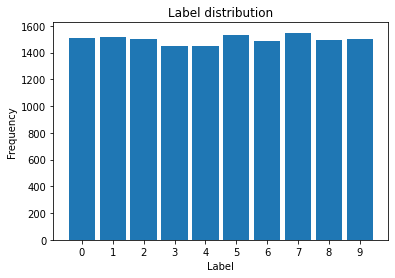

In [23]:
plot_dataset_histogram(labels=valid_labels)